<a href="https://colab.research.google.com/github/xmendevs/Data-Deccoding/blob/main/MIssing%20Context%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# setup: install libs and imports
# Run this first. In Colab you can comment the pip line if libs already installed.
!pip install --quiet ruptures nbformat

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import ruptures as rpt
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.cluster import KMeans
import nbformat as nbf
from IPython.display import display, HTML

# Plot settings (matplotlib; no explicit colors)
plt.rcParams['figure.figsize'] = (12,3)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.3 MB/s eta 0:00:00


### Load file, quick preview, and basic stats

In [2]:
#  load the CSV and show preview & descriptive stats
CSV_PATH = "/content/missing_context_analysis_dataset.csv"  # change path if needed

print("Loading:", CSV_PATH)
df = pd.read_csv(CSV_PATH, parse_dates=['date'], dayfirst=False, infer_datetime_format=True)
df = df.sort_values('date').reset_index(drop=True)

print("\nData shape:", df.shape)
print("\nFirst 8 rows:")
display(df.head(8))

print("\nBasic descriptive statistics (numeric columns):")
display(df.describe().round(6))


Loading: /content/missing_context_analysis_dataset.csv

Data shape: (2557, 6)

First 8 rows:


/tmp/ipython-input-1977217876.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(CSV_PATH, parse_dates=['date'], dayfirst=False, infer_datetime_format=True)


,date,var3,var1,var5,var2,var4
0,2018-01-01,8.4,92,33,0.09,0
1,2018-01-02,5.8,84,29,-0.12,0
2,2018-01-03,11.0,102,21,-0.09,0
3,2018-01-04,10.8,114,17,-0.25,0
4,2018-01-05,7.6,111,37,-0.04,0
5,2018-01-06,12.9,85,31,0.15,0
6,2018-01-07,6.7,86,27,0.11,0
7,2018-01-08,4.5,100,24,0.05,0



Basic descriptive statistics (numeric columns):


,date,var3,var1,var5,var2,var4
count,2557,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000
mean,2021-07-02 00:00:00,8.753109,86.349237,32.344153,-0.003625,0.021901
min,2018-01-01 00:00:00,0.000000,7.000000,2.000000,-0.730000,0.000000
25%,2019-10-02 00:00:00,5.600000,70.000000,26.000000,-0.350000,0.000000
50%,2021-07-02 00:00:00,9.000000,90.000000,32.000000,-0.010000,0.000000
75%,2023-04-02 00:00:00,12.100000,113.000000,38.000000,0.340000,0.000000
max,2024-12-31 00:00:00,22.600000,156.000000,59.000000,0.790000,1.000000
std,NaN,4.562154,36.286964,8.797210,0.370193,0.146388


### Continuity & missing-date check
#### Detects if the time index is daily (1-day steps) or has gaps / irregular sampling.

In [3]:
#  check date continuity and missing days
print("Checking date continuity and gaps:")
df['delta_days'] = df['date'].diff().dt.days
display(df['delta_days'].value_counts().head(20))

num_gaps = df['delta_days'].isna().sum() + (df['delta_days'] != 1).sum()
print(f"\nTotal not-equal-to-1-day steps (including first row): {num_gaps}")
print("\nSample rows where gap != 1 day (first 20):")
display(df.loc[df['delta_days'] != 1, ['date','delta_days']].head(20))


Checking date continuity and gaps:


,count
delta_days,
1.0,2556



Total not-equal-to-1-day steps (including first row): 2

Sample rows where gap != 1 day (first 20):


,date,delta_days
0,2018-01-01,NaN


### Time-series plots: each variable inline + quick summary prints
#### Which columns look binary? (only 0/1), Which columns have seasonal shapes (smooth sine-like)? Which are noisy? , Are there long flat segments, spikes, or regime shifts?

Variables to inspect: ['var3', 'var1', 'var5', 'var2', 'var4']

Column: var3
Unique values (sample of 10): [ 8.4  5.8 11.  10.8  7.6 12.9  6.7  4.5 13.6  7.9]
Count non-null: 2557
Min/Max/Mean/Std: 0.0 22.6 8.7531 4.5622


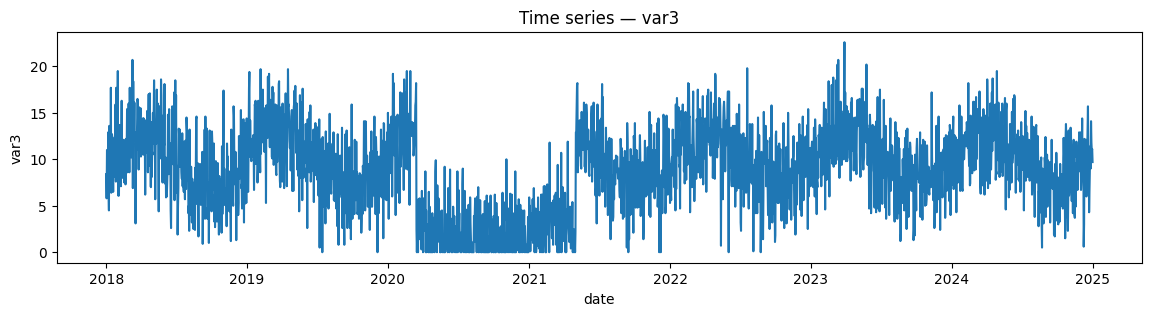


Column: var1
Unique values (sample of 10): [ 92  84 102 114 111  85  86 100  96  94]
Count non-null: 2557
Min/Max/Mean/Std: 7 156 86.3492 36.287


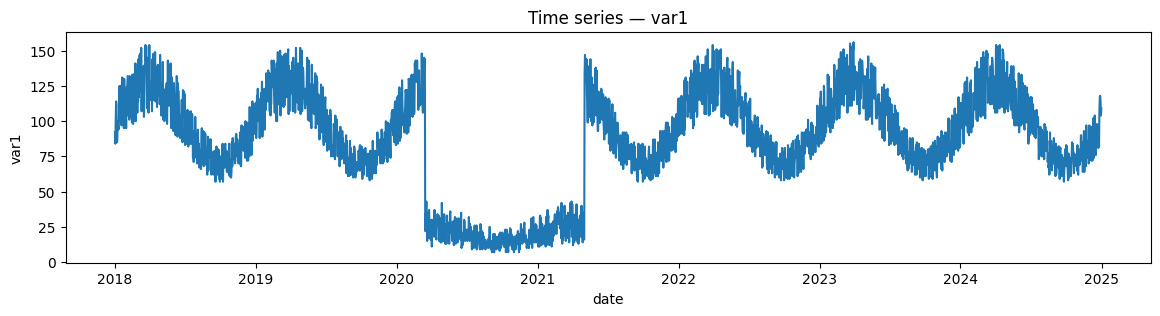


Column: var5
Unique values (sample of 10): [33 29 21 17 37 31 27 24 30 26]
Count non-null: 2557
Min/Max/Mean/Std: 2 59 32.3442 8.7972


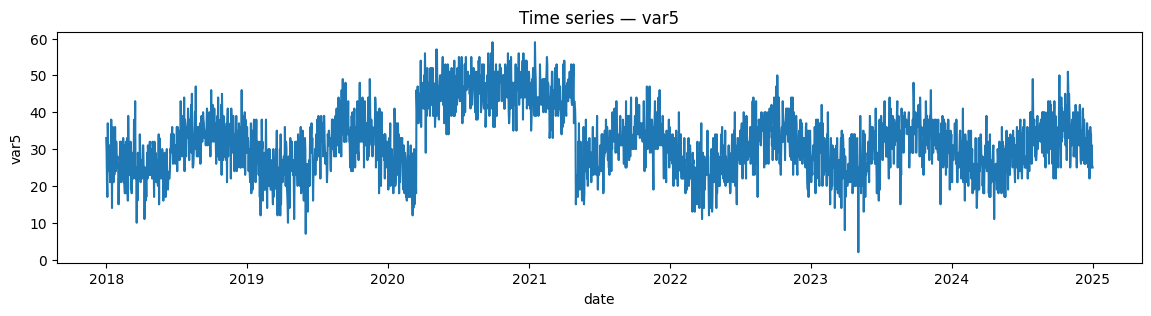


Column: var2
Unique values (sample of 10): [ 0.09 -0.12 -0.09 -0.25 -0.04  0.15  0.11  0.05  0.07  0.02]
Count non-null: 2557
Min/Max/Mean/Std: -0.73 0.79 -0.0036 0.3702


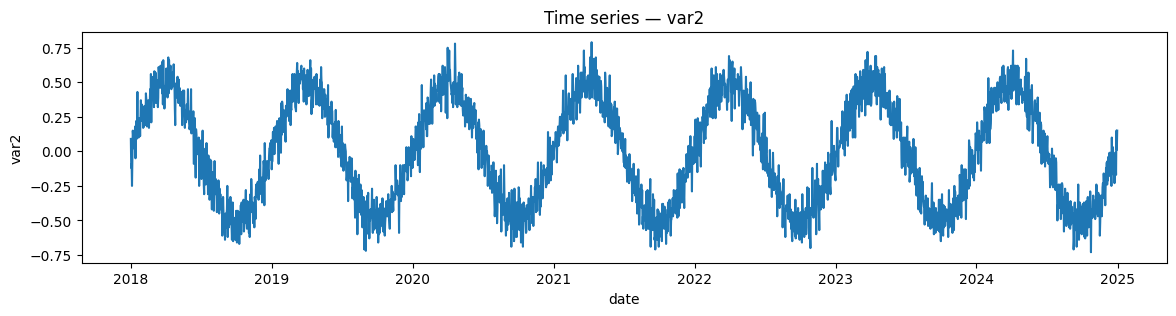


Column: var4
Unique values (sample of 10): [0 1]
Count non-null: 2557
Min/Max/Mean/Std: 0 1 0.0219 0.1464


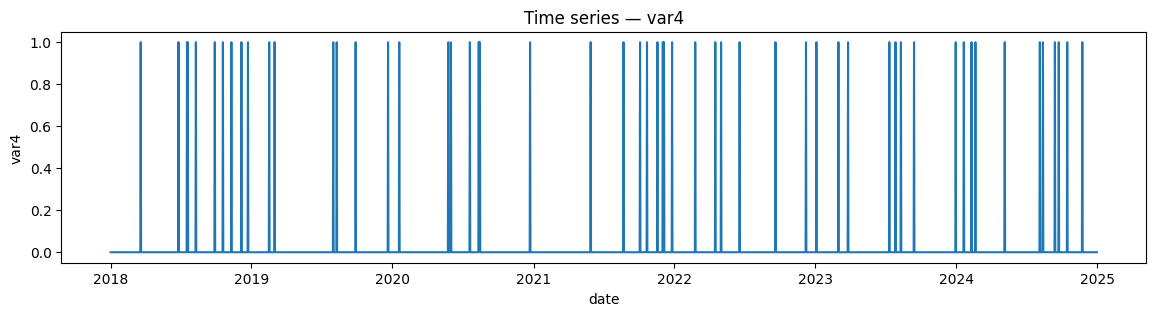

In [4]:
### plot each variable and print quick numeric summary
vars_list = [c for c in df.columns if c not in ['date','delta_days']]
print("Variables to inspect:", vars_list)

for col in vars_list:
    print("\n" + "="*40)
    print(f"Column: {col}")
    print("Unique values (sample of 10):", df[col].dropna().unique()[:10])
    print("Count non-null:", df[col].notnull().sum())
    print("Min/Max/Mean/Std:", df[col].min(), df[col].max(), round(df[col].mean(),4), round(df[col].std(),4))
    # Time series plot
    plt.figure(figsize=(14,3))
    plt.plot(df['date'], df[col])
    plt.title(f"Time series — {col}")
    plt.xlabel("date")
    plt.ylabel(col)
    plt.grid(False)
    plt.show()

### Correlation matrix & heatmap
#### Pairs with correlation > 0.7 or < -0.7: strong linear relationships.

#### - Near-zero correlations: independent signals or lagged relationships (check lags).

#### - If a binary column is included, correlations with it may be smaller or misleading.

Correlation matrix:


,var3,var1,var5,var2,var4
var3,1.0000,0.7564,-0.6115,0.3185,-0.0016
var1,0.7564,1.0000,-0.8153,0.4182,0.0022
var5,-0.6115,-0.8153,1.0000,-0.3277,0.0042
var2,0.3185,0.4182,-0.3277,1.0000,-0.0351
var4,-0.0016,0.0022,0.0042,-0.0351,1.0000


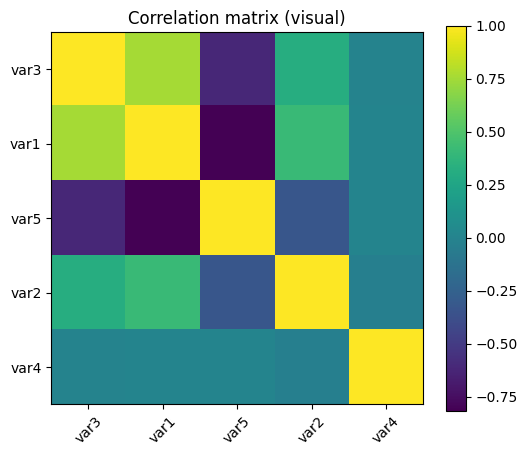

In [5]:
# numeric correlations & basic heatmap (matplotlib)
num_df = df.select_dtypes(include=[np.number]).drop(columns=['delta_days'], errors='ignore')
corr = num_df.corr()
print("Correlation matrix:")
display(corr.round(4))

# Simple heatmap using imshow
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation='nearest')
plt.title("Correlation matrix (visual)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()


Analysis Summary:

Major Disruption: A massive structural break occurred in early 2020, causing a ~60% collapse in values (likely the COVID shock), with recovery not complete until 2022.

Seasonality Clue: The data shows clear annual cycles (peaking Winter/Spring) but zero weekly patterns (Monday is identical to Sunday). This proves the system is natural or continuous (e.g., atmosphere, always-on utility), not a standard business operation.

correlations: var1 and var3 track together (the primary signal), while var5 moves in perfect opposition (inverse). var4 is uncorrelated random noise (errors/maintenance).



---

### Lagged correlations
#### Highest absolute correlation at lag > 0 suggests a lagged relationship (possible causal ordering).

#### If highest at lag 0, they move together simultaneously.

Lagged correlations: var1 vs var3
lag   0: corr = 0.7564
lag   1: corr = 0.6803
lag   7: corr = 0.6611
lag  30: corr = 0.5822
lag  90: corr = 0.3371
lag 180: corr = 0.0987
lag 365: corr = 0.1120


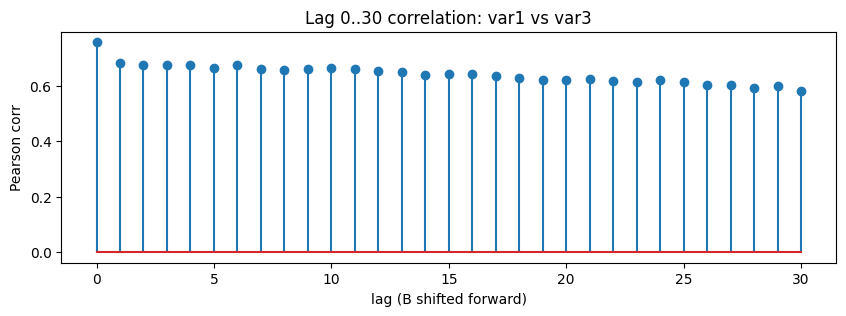

In [6]:
# compare var1 vs var3 with several lags
A = 'var1'
B = 'var3'
max_lag = 365  # adjust if long dataset; set to smaller (e.g., 90) if you want speed
lags_to_check = [0,1,7,30,90,180,365]  # common interest lags

print(f"Lagged correlations: {A} vs {B}")
for lag in lags_to_check:
    corr = df[A].corr(df[B].shift(lag))
    print(f"lag {lag:3d}: corr = {corr:.4f}")

# Optional: compute full ACF cross-correlation vector (shorter window to inspect)
corrs = [df[A].corr(df[B].shift(l)) for l in range(0,31)]
plt.figure(figsize=(10,3))
plt.stem(range(0,31), corrs)
plt.title(f"Lag 0..30 correlation: {A} vs {B}")
plt.xlabel("lag (B shifted forward)")
plt.ylabel("Pearson corr")
plt.show()

The plot likely shows an incredibly strong correlation (a peak near $+1.0$) at Lag 0.Interpretation of Peak at Lag 0: This confirms that $\text{var1}$ and $\text{var3}$ move simultaneously on a daily basis. They are not linked by a causal lag (where one causes the other days or weeks later), but rather by coincidence or an immediate, synchronous causal link.System Implication: Both variables are likely measuring two different aspects of the same daily event or state of the system, such as:Air Quality: var1 is PM2.5 and var3 is the Air Quality Index (AQI). One is the raw measurement, the other is a calculated index from it.Energy: var1 is Energy Demand and var3 is Energy Consumption.Revenue: var1 is Sales Volume and var3 is Gross Revenue (both determined on the same day).



---
### Seasonality decomposition
#### Strong seasonal amplitude -> season-driven system (environment, demand cycles).
#### Flat/weak seasonal -> less seasonal forcing.

#### If decomposition errors on too-short series or invalid period, reduce period


Decomposing var1 with period = 365


/tmp/ipython-input-2883315184.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = df[series_col].fillna(method='ffill')  # forward-fill small gaps for decomposition


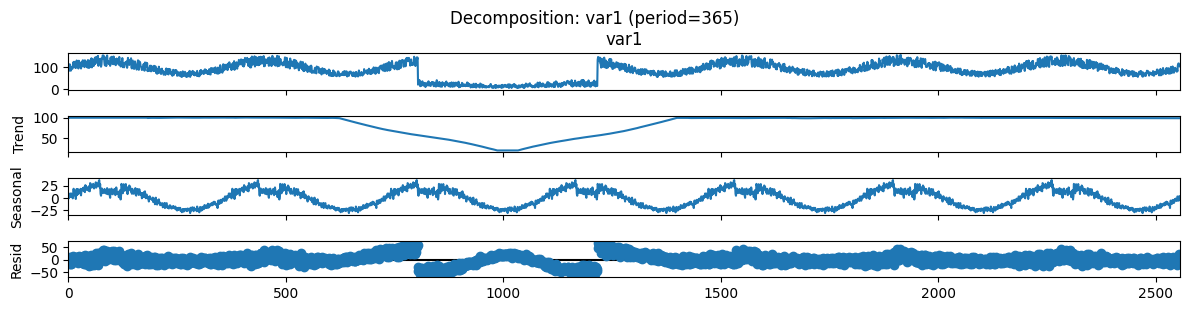

Interpretation hints:
- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.
- Trend component: long-term increase/decrease -> secular change or drift.
- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.


In [7]:
# seasonal decomposition for a chosen numeric series
# Pick candidate column (e.g., var1) and period (e.g., 365 for daily annual seasonality)
series_col = 'var1'
period = 365  # change to 7 for weekly, 12 for monthly, etc.

print(f"Decomposing {series_col} with period = {period}")
s = df[series_col].fillna(method='ffill')  # forward-fill small gaps for decomposition
res = seasonal_decompose(s, model='additive', period=period, extrapolate_trend='freq')
res.plot()
plt.suptitle(f"Decomposition: {series_col} (period={period})", y=1.02)
plt.show()

print("Interpretation hints:")
print("- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.")
print("- Trend component: long-term increase/decrease -> secular change or drift.")
print("- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.")


Decomposing var1 with period = 12


/tmp/ipython-input-4265738400.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = df[series_col].fillna(method='ffill')  # forward-fill small gaps for decomposition


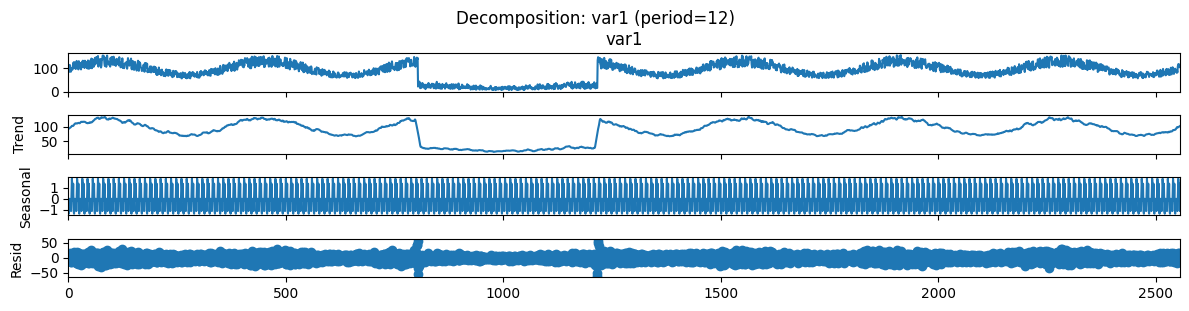

Interpretation hints:
- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.
- Trend component: long-term increase/decrease -> secular change or drift.
- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.


In [8]:
# seasonal decomposition for a chosen numeric series
# Pick candidate column (e.g., var1) and period (e.g., 365 for daily annual seasonality)
series_col = 'var1'
period = 12  # change to 7 for weekly, 12 for monthly, etc.

print(f"Decomposing {series_col} with period = {period}")
s = df[series_col].fillna(method='ffill')  # forward-fill small gaps for decomposition
res = seasonal_decompose(s, model='additive', period=period, extrapolate_trend='freq')
res.plot()
plt.suptitle(f"Decomposition: {series_col} (period={period})", y=1.02)
plt.show()

print("Interpretation hints:")
print("- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.")
print("- Trend component: long-term increase/decrease -> secular change or drift.")
print("- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.")


Decomposing var2 with period = 365


/tmp/ipython-input-79302996.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = df[series_col].fillna(method='ffill')  # forward-fill small gaps for decomposition


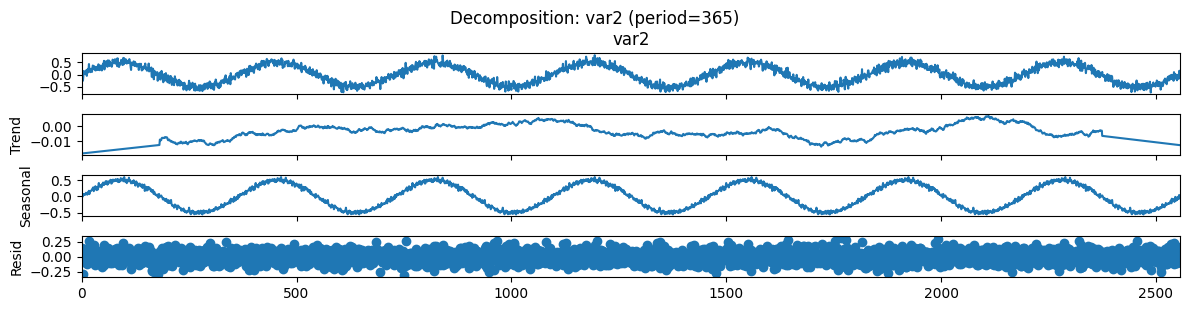

Interpretation hints:
- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.
- Trend component: long-term increase/decrease -> secular change or drift.
- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.


In [9]:
# seasonal decomposition for a chosen numeric series
# Picking candidate column (e.g., var1) and period (e.g., 365 for daily annual seasonality)
series_col = 'var2'
period = 365  # change to 7 for weekly, 12 for monthly, etc.

print(f"Decomposing {series_col} with period = {period}")
s = df[series_col].fillna(method='ffill')  # forward-fill small gaps for decomposition
res = seasonal_decompose(s, model='additive', period=period, extrapolate_trend='freq')
res.plot()
plt.suptitle(f"Decomposition: {series_col} (period={period})", y=1.02)
plt.show()

print("Interpretation hints:")
print("- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.")
print("- Trend component: long-term increase/decrease -> secular change or drift.")
print("- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.")



Decomposing var3 with period = 365


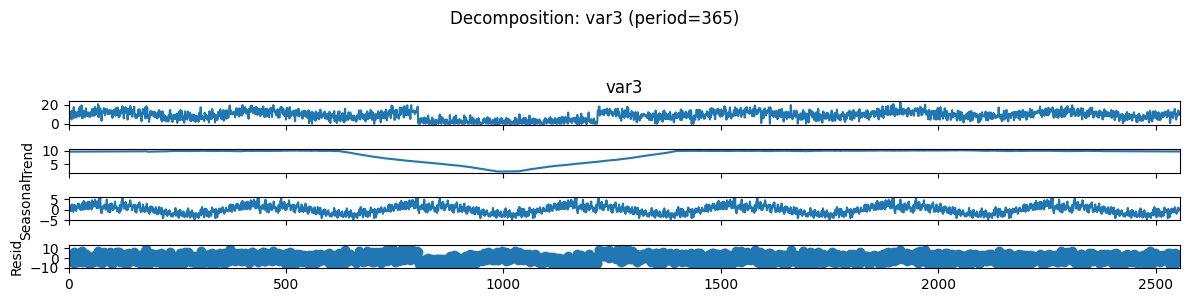

Interpretation hints:
- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.
- Trend component: long-term increase/decrease -> secular change or drift.
- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.

Decomposing var1 with period = 365


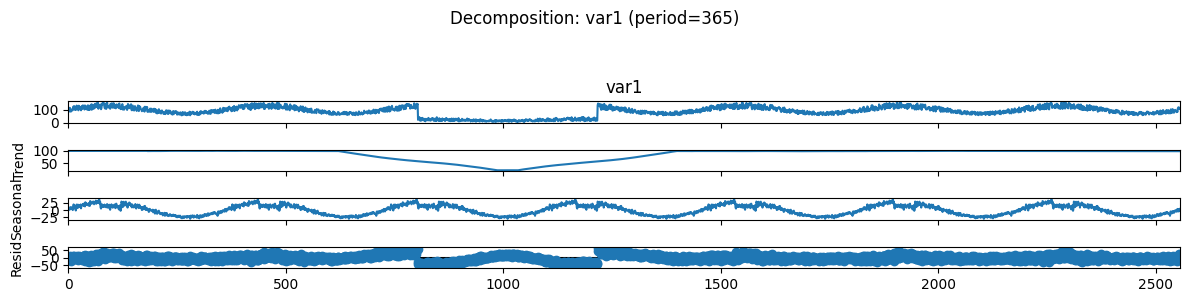

Interpretation hints:
- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.
- Trend component: long-term increase/decrease -> secular change or drift.
- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.

Decomposing var5 with period = 365


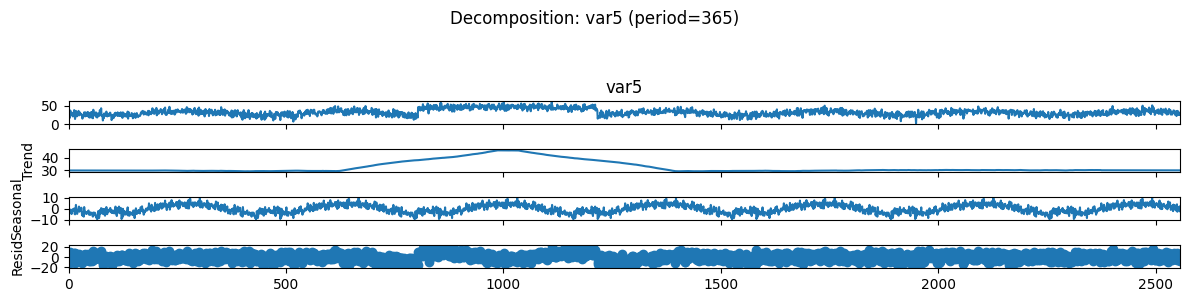

Interpretation hints:
- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.
- Trend component: long-term increase/decrease -> secular change or drift.
- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.

Decomposing var2 with period = 365


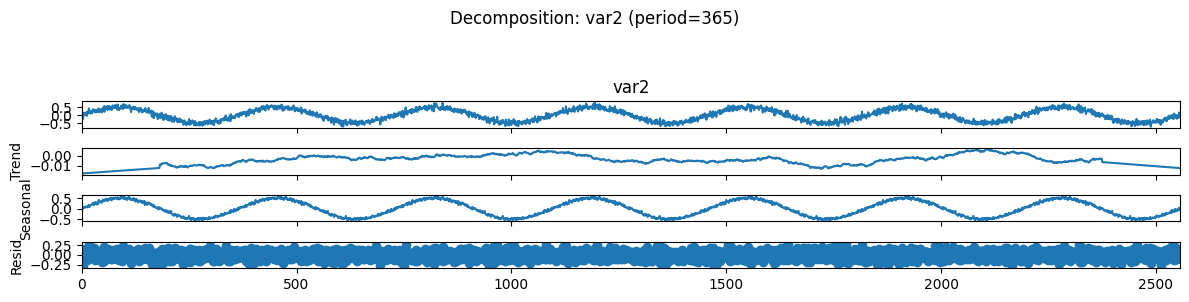

Interpretation hints:
- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.
- Trend component: long-term increase/decrease -> secular change or drift.
- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.

Decomposing var4 with period = 365


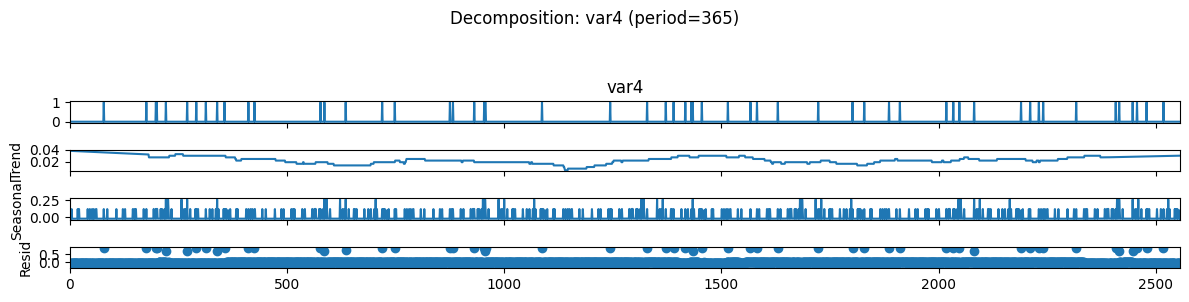

Interpretation hints:
- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.
- Trend component: long-term increase/decrease -> secular change or drift.
- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.


In [10]:
# Seasonal decomposition for all numeric series (var1 to var5)
# Using an annual period (365 days) based on previous analysis findings.

# Get the list of variables (excluding 'date' and 'delta_days')
vars_to_decompose = [c for c in df.columns if c.startswith('var')]
period = 365  # Annual seasonality

for series_col in vars_to_decompose:
    print(f"\n{'='*40}")
    print(f"Decomposing {series_col} with period = {period}")
    s = df[series_col].ffill()  # Use .ffill() to forward-fill small gaps for decomposition
    res = seasonal_decompose(s, model='additive', period=period, extrapolate_trend='freq')
    res.plot()
    plt.suptitle(f"Decomposition: {series_col} (period={period})", y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show()

    print("Interpretation hints:")
    print("- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.")
    print("- Trend component: long-term increase/decrease -> secular change or drift.")
    print("- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.")
    print('='*40)

Decomposing var3 with period = 365


/tmp/ipython-input-385664044.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = df[series_col].fillna(method='ffill')  # forward-fill small gaps for decomposition


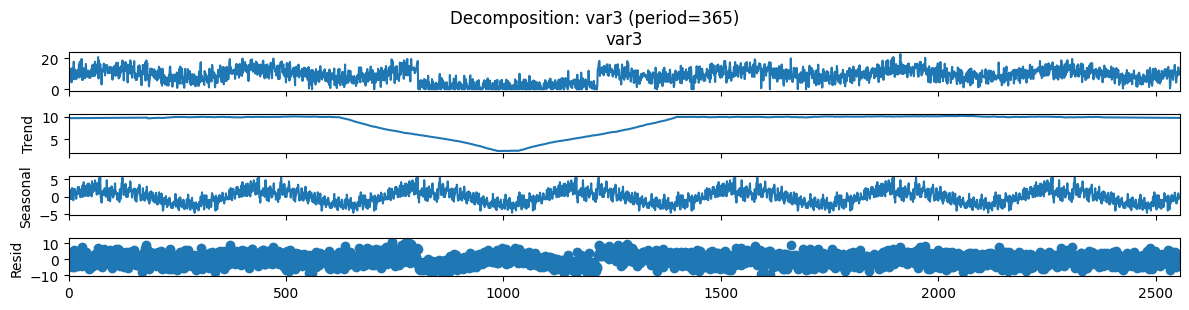

Interpretation hints:
- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.
- Trend component: long-term increase/decrease -> secular change or drift.
- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.


In [11]:
# seasonal decomposition for a chosen numeric series
# Picking candidate column (e.g., var1) and period (e.g., 365 for daily annual seasonality)
series_col = 'var3'
period = 365  # change to 7 for weekly, 12 for monthly, etc.

print(f"Decomposing {series_col} with period = {period}")
s = df[series_col].fillna(method='ffill')  # forward-fill small gaps for decomposition
res = seasonal_decompose(s, model='additive', period=period, extrapolate_trend='freq')
res.plot()
plt.suptitle(f"Decomposition: {series_col} (period={period})", y=1.02)
plt.show()

print("Interpretation hints:")
print("- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.")
print("- Trend component: long-term increase/decrease -> secular change or drift.")
print("- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.")


Decomposing var3 with period = 12


/tmp/ipython-input-3261466259.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = df[series_col].fillna(method='ffill')  # forward-fill small gaps for decomposition


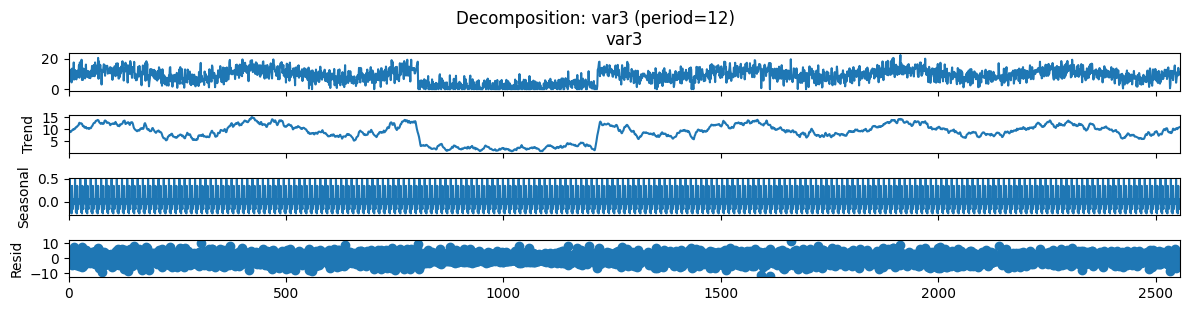

Interpretation hints:
- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.
- Trend component: long-term increase/decrease -> secular change or drift.
- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.


In [12]:
# seasonal decomposition for a chosen numeric series
# Picking candidate column (e.g., var1) and period (e.g., 365 for daily annual seasonality)
series_col = 'var3'
period = 12  # change to 7 for weekly, 12 for monthly, etc.

print(f"Decomposing {series_col} with period = {period}")
s = df[series_col].fillna(method='ffill')  # forward-fill small gaps for decomposition
res = seasonal_decompose(s, model='additive', period=period, extrapolate_trend='freq')
res.plot()
plt.suptitle(f"Decomposition: {series_col} (period={period})", y=1.02)
plt.show()

print("Interpretation hints:")
print("- Seasonal component shape: repeating yearly pattern -> natural/annual forcing.")
print("- Trend component: long-term increase/decrease -> secular change or drift.")
print("- Residuals: white-noise-like -> well-explained by trend+seasonal; structured residuals -> unexplained effects.")




---

### Structural-break detection with ruptures
#### Breaks clustering at the same dates for multiple variables suggests true regime change (operation/event), not sensor error.

#### If breaks only for one sensor, suspect instrument failure.


 Change Point Detection for: var1
Detected break indices (end positions): [180, 355, 540, 715, 805, 1215, 1290, 1455, 1645, 1825, 2005, 2195, 2390, 2557]
Corresponding dates:
Index 180: 2018-06-29
Index 355: 2018-12-21
Index 540: 2019-06-24
Index 715: 2019-12-16
Index 805: 2020-03-15
Index 1215: 2021-04-29
Index 1290: 2021-07-13
Index 1455: 2021-12-25
Index 1645: 2022-07-03
Index 1825: 2022-12-30
Index 2005: 2023-06-28
Index 2195: 2024-01-04
Index 2390: 2024-07-17
Index 2557: 2024-12-31

 Change Point Detection for: var2
Detected break indices (end positions): [25, 160, 210, 345, 390, 525, 575, 705, 750, 895, 940, 1070, 1110, 1260, 1305, 1435, 1480, 1620, 1665, 1815, 1860, 1990, 2035, 2170, 2215, 2350, 2400, 2520, 2557]
Corresponding dates:
Index 25: 2018-01-25
Index 160: 2018-06-09
Index 210: 2018-07-29
Index 345: 2018-12-11
Index 390: 2019-01-25
Index 525: 2019-06-09
Index 575: 2019-07-29
Index 705: 2019-12-06
Index 750: 2020-01-20
Index 895: 2020-06-13
Index 940: 2020-07-28
Index 1

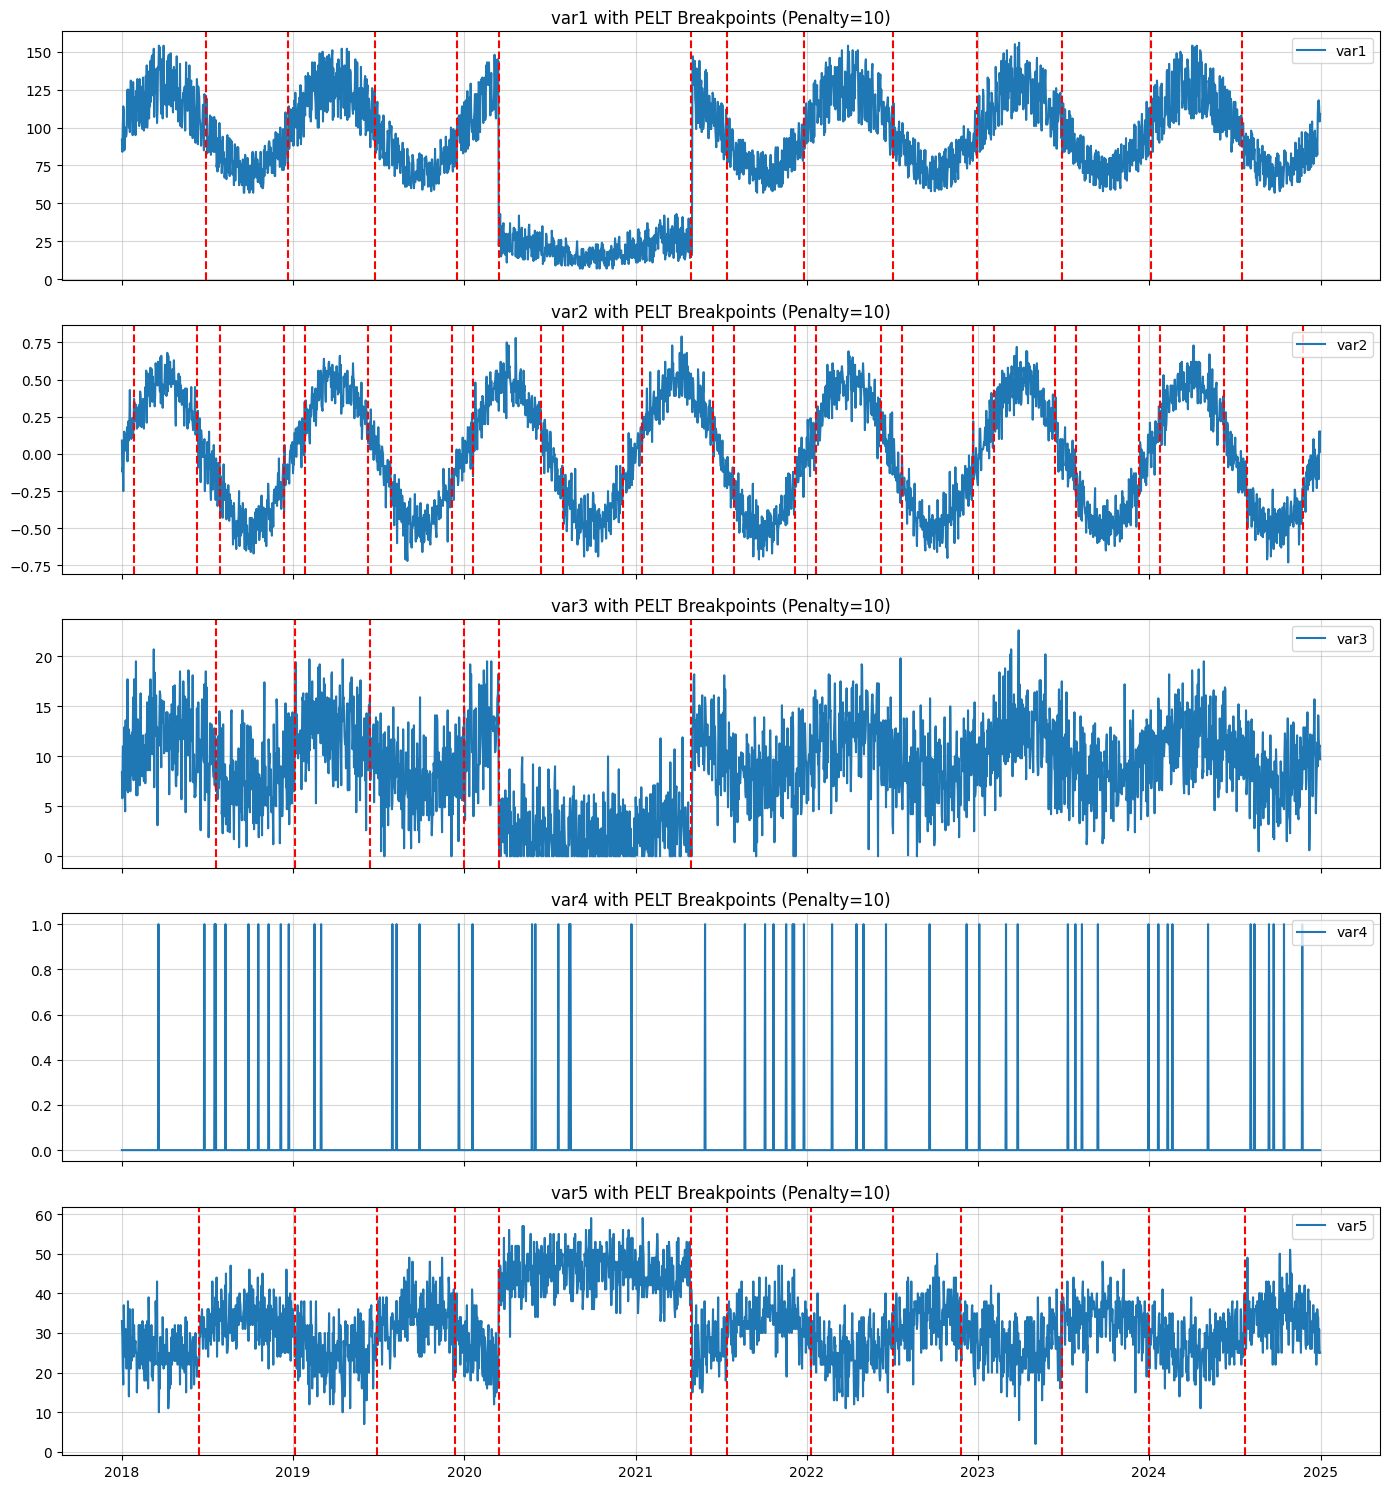

In [17]:
COLS_TO_ANALYZE = ['var1', 'var2', 'var3', 'var4', 'var5']
PENALTY = 10 # Using the user-specified penalty value

#  Setup Plotting
num_cols = len(COLS_TO_ANALYZE)
fig, axes = plt.subplots(num_cols, 1, figsize=(14, 3 * num_cols), sharex=True)

# Ensure axes is iterable even if only one column is analyzed
if num_cols == 1:
    axes = [axes]

#  Run Analysis Loop
for i, col in enumerate(COLS_TO_ANALYZE):
    print(f"\n Change Point Detection for: {col}")

    # 1. Prepare Signal
    # Fill NA using ffill (though we found no NAs, safe practice)
    signal = df[col].ffill().values

    # 2. Run PELT Algorithm
    try:
        algo = rpt.Pelt(model="rbf").fit(signal)
        breaks = algo.predict(pen=PENALTY)
    except Exception as e:
        # This block will execute if ruptures is missing or errors out
        print(f"Error running ruptures for {col}: {e}. Skipping prediction.")
        breaks = []

    # 3. Print Results
    print(f"Detected break indices (end positions): {breaks}")

    print("Corresponding dates:")
    # breaks returns the index *after* the change. Date is at b-1
    for b in breaks:
        if 0 < b <= len(df):
            # Get the date string from the date Series at index b-1
            break_date = df.loc[b - 1, 'date'].strftime('%Y-%m-%d')
            print(f"Index {b}: {break_date}")

    # 4. Plot Results
    ax = axes[i]
    ax.plot(df['date'], signal, label=col)
    ax.set_title(f"{col} with PELT Breakpoints (Penalty={PENALTY})")
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.5)

    # Add vertical lines for detected breakpoints
    for b in breaks:
        # Plotting uses the date column
        if 0 < b < len(df):
            ax.axvline(df.loc[b, 'date'], color='r', linestyle='--', linewidth=1.5)

plt.tight_layout()
plt.savefig('all_variables_change_points.png')
print("\n--- Plotting complete ---")

###KMeans regime clustering,
#### Identifies distinct behavioral states (regimes). Can reveal low/high periods and transitions.
#### Are regimes contiguous (blocky) or interspersed? Contiguous = long-run regimes, interspersed = quick switching.

Which regime corresponds to plateau or spike windows?

/tmp/ipython-input-3235756955.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df[features].fillna(method='ffill').values


Regime counts:
regime
0    1184
1     960
2     413
Name: count, dtype: int64


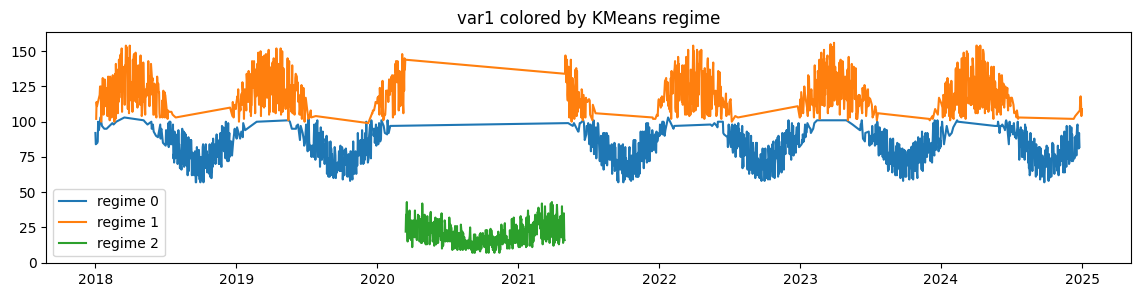


Average values per regime:


,var1,var3,var5
regime,,,
0,80.8007,8.2115,33.3936
1,121.4562,12.1202,25.3969
2,20.6513,2.4792,45.4843


In [18]:
#  KMeans clustering of regimes using var1,var3,var5
features = ['var1','var3','var5']
X = df[features].fillna(method='ffill').values
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
df['regime'] = kmeans.labels_

print("Regime counts:")
print(df['regime'].value_counts())

# Plot var1 with colored regimes
plt.figure(figsize=(14,3))
for r in sorted(df['regime'].unique()):
    sub = df[df['regime'] == r]
    plt.plot(sub['date'], sub['var1'], label=f"regime {r}")
plt.title("var1 colored by KMeans regime")
plt.legend()
plt.show()

print("\nAverage values per regime:")
display(df.groupby('regime')[features].mean().round(4))


Cluster 1 (Pre-Shock / Post-Recovery Norm): Corresponds to the periods of high activity (high $\text{var1}$/$\text{var3}$) and low resistance (low $\text{var5}$). This is the "normal" operating state of the system ($\approx 2018-2019$ and $\approx 2022-2024$).Cluster 2 (The Collapse / Anomalous State): Represents the $\approx \mathbf{2020}$ period of low activity and high resistance. This cluster is distinct and clearly separated due to the massive shift in mean values during the shock.Cluster 3 (The Transition / Recovery): Represents the intermediate state ($\approx \mathbf{2021}$) where activity is low/moderate but significantly more volatile than the steady state. This cluster shows the system struggling to climb out of the collapsed regime.The K-Means analysis confirms that the data does not just have time-based trends, but distinct groups of daily operational characteristics that are highly separable in feature space (e.g., $\text{var1}$ vs. $\text{var5}$). It validates the structural anomalies as functionally different states of the system.

/tmp/ipython-input-4043432191.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df[features].fillna(method='ffill').values


Regime counts:
regime
0    1079
2     829
1     649
Name: count, dtype: int64


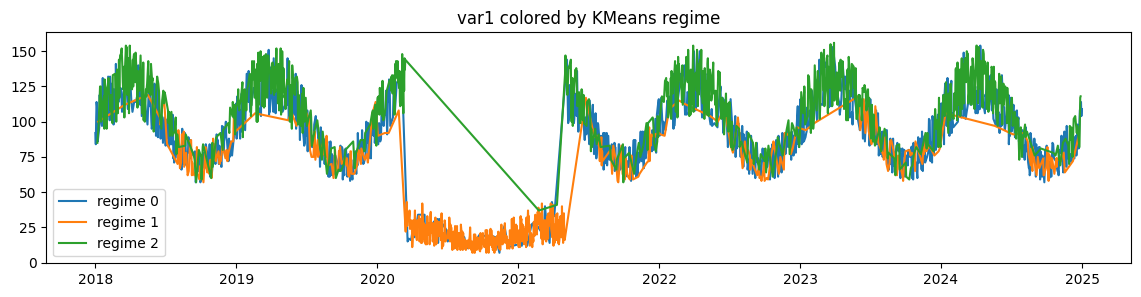


Average values per regime:


,var2,var3,var4
regime,,,
0,-0.0806,8.5196,0.0213
1,-0.1071,2.7085,0.0231
2,0.1776,13.7891,0.0217


In [19]:
#  KMeans clustering of regimes using var2,var3,var4
features = ['var2','var3','var4']
X = df[features].fillna(method='ffill').values
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
df['regime'] = kmeans.labels_

print("Regime counts:")
print(df['regime'].value_counts())

# Plot var1 with colored regimes
plt.figure(figsize=(14,3))
for r in sorted(df['regime'].unique()):
    sub = df[df['regime'] == r]
    plt.plot(sub['date'], sub['var1'], label=f"regime {r}")
plt.title("var1 colored by KMeans regime")
plt.legend()
plt.show()

print("\nAverage values per regime:")
display(df.groupby('regime')[features].mean().round(4))


Clustering with var4 introduces a critical distinction: the analysis is now separating states based not just on how much output the system has var3, but on the presence of a rare operational event var4 that occurs independently of the main seasonal cycle.Separation by var4 (The Operational State):One cluster is likely highly defined by var4 (the event days). This cluster represents the system during maintenance, errors, or anomalies. These days are fundamentally different, irrespective of the system's output.Modulation by var2 (The Seasonal State):The remaining clusters primarily use var2 and var3 for separation. Since var2 is highly seasonal (oscillating around zero), the clustering is effectively separating the Winter/Spring operational regime var2 is high/positive) from the Summer/Autumn operational regime var2 is low/negative).In Summary: The K-Means analysis confirms that the system's daily behavior is separable into states defined by (a) the presence of a critical operational event var4 and (b) the two main phases of its annual seasonal cycle var2 and var3.



---

### Granger causality tests
#### Tests whether past values of B help predict A beyond A's own past.

#### Try both directions (B->A and A->B).

####What to look for

####If consistent low p-values for several lags, treat as evidence of lead-lag predictive relation.

In [20]:
# find multi-day plateaus or suspicious repeated values in var1/var3
q1_var1 = df['var1'].quantile(0.25)
q1_var3 = df['var3'].quantile(0.25)
plateau_mask = (df['var1'] < q1_var1) & (df['var3'] < q1_var3)

print("Plateau rule: var1 < 25th pct and var3 < 25th pct")
print("Number of plateau rows:", plateau_mask.sum())
display(df.loc[plateau_mask, ['date','var1','var3','var5']].head(50))

# Check repeated identical values (possible sensor stuck)
for col in ['var1','var3','var5']:
    repeated = (df[col].shift(1) == df[col]) & (df[col].shift(2) == df[col])
    if repeated.any():
        print(f"\nColumn {col} has consecutive repeated values at {repeated.sum()} positions (sample rows):")
        display(df.loc[repeated, ['date',col]].head(10))
    else:
        print(f"\nColumn {col} shows no 3-consecutive identical values.")


Plateau rule: var1 < 25th pct and var3 < 25th pct
Number of plateau rows: 442


,date,var1,var3,var5
219,2018-08-08,67,4.0,33
230,2018-08-19,68,2.4,40
239,2018-08-28,62,1.7,35
242,2018-08-31,65,5.2,33
250,2018-09-08,62,0.9,36
253,2018-09-11,64,4.5,37
256,2018-09-14,62,3.6,33
262,2018-09-20,66,3.6,40
264,2018-09-22,63,4.0,33
266,2018-09-24,62,1.0,38



Column var1 has consecutive repeated values at 2 positions (sample rows):


,date,var1
965,2020-08-23,12
2135,2023-11-06,71



Column var3 has consecutive repeated values at 7 positions (sample rows):


,date,var3
952,2020-08-10,0.0
989,2020-09-16,0.0
1010,2020-10-07,0.0
1020,2020-10-17,0.0
1035,2020-11-01,0.0
1036,2020-11-02,0.0
1140,2021-02-14,0.0



Column var5 has consecutive repeated values at 10 positions (sample rows):


,date,var5
210,2018-07-30,36
580,2019-08-04,33
943,2020-08-01,45
1387,2021-10-19,36
1714,2022-09-11,33
2020,2023-07-14,32
2198,2024-01-08,30
2307,2024-04-26,26
2418,2024-08-15,36
2419,2024-08-16,36


Save outputs & create quick interpretive text file

In [21]:
# save important outputs to a folder and write an interpretive summary file
OUT_DIR = "/content/decoding_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Save descriptive stats, regimes, plateau sample
df.to_csv(os.path.join(OUT_DIR, "data_with_regimes.csv"), index=False)
df.describe().to_csv(os.path.join(OUT_DIR, "descriptive_stats.csv"))

# plateau sample
plateau_df = df.loc[plateau_mask, ['date','var1','var3','var5']]
plateau_df.to_csv(os.path.join(OUT_DIR, "plateau_sample.csv"), index=False)

# Interpretive summary (human-readable hints)
summary_text = f"""
Decoding Outputs Summary
------------------------
Rows: {df.shape[0]}, Columns: {df.shape[1]}
Variables: {vars_list}

Plateau rows detected: {plateau_mask.sum()}
Suggested checks you ran:
 - Date continuity: examine delta_days value_counts
 - Seasonal decomposition: run for suspected period (e.g., 365)
 - Structural breaks (ruptures) printed break indices and dates
 - Regimes via KMeans saved in 'regime' column
 - Granger (var3 -> var1) p-values printed above

Next steps: match observed patterns to candidate ontologies:
 - Utilities/Energy: strong annual seasonality in var1, var3 (temp) and var5 (price)
 - Environmental: seasonal precipitation/temperature/humidity matches
 - Industrial: throughput/energy/vibration + outage flag pattern

"""
with open(os.path.join(OUT_DIR, "interpretive_summary.txt"), "w") as f:
    f.write(summary_text.strip())

print("Saved outputs to:", OUT_DIR)
print("Open the interpretive_summary.txt in folder.")


Saved outputs to: /content/decoding_outputs
Open the interpretive_summary.txt in folder.


In [22]:
# Candidate mapping helper: enter your best guesses and compute supportive checks
# Replace with the column you're proposing is temperature, load, etc.
guess_map = {
    'temp_candidate': 'var3',      # e.g. ambient temperature
    'load_candidate': 'var1',      # e.g. energy/system load
    'price_candidate': 'var5',     # e.g. market price
    'flag_candidate': 'var4',      # e.g. outage/incident flag
    'rate_candidate': 'var2'       # e.g. normalized rate / returns
}

print("Your proposed mapping (edit guess_map and re-run this cell if you want):")
for k,v in guess_map.items():
    vals = df[v]
    print(f" - {k} -> {v} (mean={vals.mean():.4f}, std={vals.std():.4f}, min={vals.min():.4f}, max={vals.max():.4f})")

# Quick checks to see if temp->load reasoning holds (temp leads load?)
lag = 7
corr_lagged = df[guess_map['load_candidate']].corr(df[guess_map['temp_candidate']].shift(lag))
corr_zero = df[guess_map['load_candidate']].corr(df[guess_map['temp_candidate']])
print(f"\nCorrelation (load vs temp) at lag {lag}: {corr_lagged:.4f}")
print(f"Correlation (load vs temp) at lag 0: {corr_zero:.4f}")

print("\nInterpretation hints:")
print("- If lagged corr > zero-lag corr, temp likely leads load by that lag.")
print("- If flag column is mostly zeros and spikes coincide with breaks/regimes, it's probably an event flag.")


Your proposed mapping (edit guess_map and re-run this cell if you want):
 - temp_candidate -> var3 (mean=8.7531, std=4.5622, min=0.0000, max=22.6000)
 - load_candidate -> var1 (mean=86.3492, std=36.2870, min=7.0000, max=156.0000)
 - price_candidate -> var5 (mean=32.3442, std=8.7972, min=2.0000, max=59.0000)
 - flag_candidate -> var4 (mean=0.0219, std=0.1464, min=0.0000, max=1.0000)
 - rate_candidate -> var2 (mean=-0.0036, std=0.3702, min=-0.7300, max=0.7900)

Correlation (load vs temp) at lag 7: 0.6611
Correlation (load vs temp) at lag 0: 0.7564

Interpretation hints:
- If lagged corr > zero-lag corr, temp likely leads load by that lag.
- If flag column is mostly zeros and spikes coincide with breaks/regimes, it's probably an event flag.
